In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [2]:
# Set dataset path
base_dir = "../dataset"

# List categories (folders in dataset)
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Image size to resize to
img_size = 224

# Batch size for training
batch_size = 32


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% training, 20% validation
)

# Load training images
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation images
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 479 images belonging to 6 classes.
Found 118 images belonging to 6 classes.


In [4]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Create the base model from the pre-trained EfficientNetV2B2
base_model = EfficientNetV2B2(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')  # 6 classes: cardboard, glass, metal, paper, plastic, trash
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,950,500 (34.14 MB)

 Trainable params: 181,126 (707.52 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [5]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load EfficientNetV2B2 base model (without top layer)
base_model = EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

# Freeze all layers in the base model
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(6, activation='softmax')(x)  # 6 output classes

# Final model
model = Model(inputs=base_model.input, outputs=predictions)


In [6]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [7]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # You can increase for better accuracy
    validation_data=val_generator
)


Epoch 1/30


/Users/devidesai28/Documents/garbage-project/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 702ms/step - accuracy: 0.1728 - loss: 1.8042 - val_accuracy: 0.1610 - val_loss: 1.7971
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 549ms/step - accuracy: 0.1873 - loss: 1.8036 - val_accuracy: 0.1610 - val_loss: 1.7932
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 547ms/step - accuracy: 0.1511 - loss: 1.8124 - val_accuracy: 0.1864 - val_loss: 1.7924
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 550ms/step - accuracy: 0.1378 - loss: 1.8200 - val_accuracy: 0.1441 - val_loss: 1.7917
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 553ms/step - accuracy: 0.1576 - loss: 1.8114 - val_accuracy: 0.1610 - val_loss: 1.7917
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 565ms/step - accuracy: 0.1560 - loss: 1.8090 - val_accuracy: 0.1610 - val_loss: 1.7921
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 577ms/step - accuracy: 0.1692 - loss: 1.8186 - val_accuracy: 0.1864 - val_loss: 1.7914
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 586ms/step - accuracy: 0.2004 - loss: 1.7948 - val_accuracy: 0.1780 - val

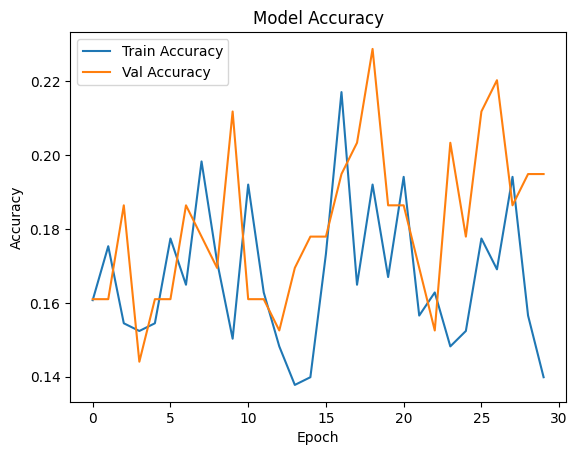

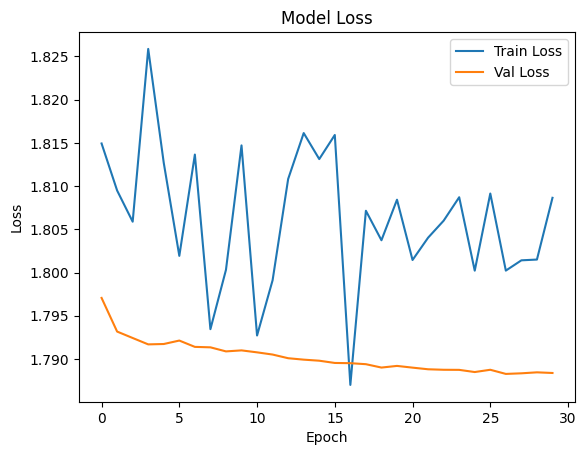

In [12]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
model.save("garbage_classifier_model.h5")


In [14]:
print(train_generator.class_indices)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [16]:
print("Raw Prediction:", prediction)
print("Predicted Index:", np.argmax(prediction))
print("Predicted Class:", categories[np.argmax(prediction)])


NameError: name 'prediction' is not defined

In [17]:
import os
from collections import Counter

train_dir = '/Users/devidesai28/Documents/garbage-project/dataset'
class_counts = {}

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print("Class counts:", class_counts)


Class counts: {'paper': 100, 'metal': 100, 'cardboard': 100, 'trash': 100, 'glass': 100, 'plastic': 99}


In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = list(class_counts.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(labels),
    y=[label for label in labels for _ in range(class_counts[label])]
)

# Map weights to class indices
class_weight_dict = {i: class_weights[i] for i in range(len(labels))}
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.9983333333333333), 1: np.float64(0.9983333333333333), 2: np.float64(0.9983333333333333), 3: np.float64(0.9983333333333333), 4: np.float64(0.9983333333333333), 5: np.float64(1.0084175084175084)}


In [19]:
import os

dataset_path = "/Users/devidesai28/Documents/garbage-project/dataset"

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        print(f"{category}: {len(os.listdir(category_path))} images")


paper: 100 images
metal: 100 images
cardboard: 100 images
trash: 100 images
glass: 100 images
plastic: 99 images


In [20]:
import os
import random

# Folder path to the 'paper' category
paper_folder = "/Users/devidesai28/Documents/garbage-project/dataset/paper"

# Number of images to KEEP (adjust this to match other classes)
keep_count = 400

# Get all image file names in paper folder
all_images = os.listdir(paper_folder)

# Shuffle the list
random.shuffle(all_images)

# Only keep first N images, delete the rest
for image in all_images[keep_count:]:
    img_path = os.path.join(paper_folder, image)
    os.remove(img_path)

print(f"Reduced paper folder to {keep_count} images.")


Reduced paper folder to 400 images.


In [21]:
import os
import random

dataset_path = '/Users/devidesai28/Documents/garbage-project/test_images/cardboard_003.jpg'
target_count = 100  # Number of images to keep per category

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        all_images = os.listdir(category_path)
        total_images = len(all_images)

        if total_images > target_count:
            # Too many images — randomly delete extra
            extra = all_images[target_count:]
            for image in extra:
                img_path = os.path.join(category_path, image)
                os.remove(img_path)
            print(f"✅ {category}: Reduced from {total_images} → {target_count}")
        elif total_images < target_count:
            print(f"⚠️ {category}: Only {total_images} images — need {target_count}")
        else:
            print(f"✔️ {category}: Already balanced")


NotADirectoryError: [Errno 20] Not a directory: '/Users/devidesai28/Documents/garbage-project/test_images/cardboard_003.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: glass


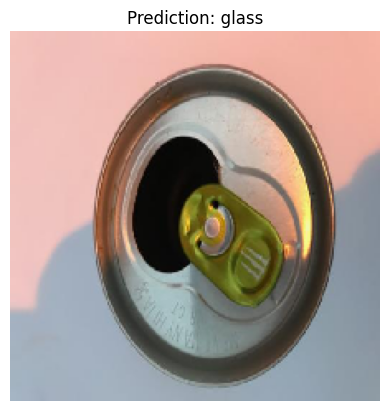

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Class labels
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Correct image path (must exist!)
img_path = '/Users/devidesai28/Documents/garbage-project/test_images/metal_026.jpg'

# Load and preprocess
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
predicted_class = categories[np.argmax(prediction)]

# Show result
print(f"Predicted Class: {predicted_class}")
plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')
plt.show()
